In [1]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from time import time
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
idx = pd.IndexSlice
YEAR = 252

In [2]:
sns.__version__

'0.11.1'

In [3]:
with pd.HDFStore('data/data.h5') as store:
    data = (store['model_data'].dropna().drop(['open', 'close', 'low', 'high'], axis=1))

In [4]:
data.index.names = ['symbol', 'date']
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)[data.dollar_vol_rank < 100]

In [5]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_mid                 109675 non-null  float64
 7   bb_low                 109675 non-null  float64
 8   atr                    109675 non-null  float64
 9   macd                   109675 non-null  float64
 10  return_1d              109675 non-null  float64
 11  return_5d              109675 non-null  float64
 12  return_10d             109675 non-null  float64
 13  return_21d    

In [6]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [7]:
class MultipleTimeSeriesCV:
    def __init__(self, n_splits=3, train_period_length=126, test_period_length=21, lookahead=None, shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start]) & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start]) & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [8]:
train_period_length = 63 # 3months
test_period_length = 10 # predict for 10 days after test period
n_splits = int(3 * YEAR/test_period_length)
lookahead =1

cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_period_length,
                          lookahead=lookahead, train_period_length=train_period_length)

i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


In [9]:
# Prediction vs Actual Scatter Plot
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals', robust=True, ci=None, line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1}, data=df, kind='reg')
    j.ax_joint.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

In [10]:
# Daily IC Distribution
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')

In [11]:
# Rolling Daily IC
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0], title=f'Information Coefficient (Mean: {mean_ic:.2f})', lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1], title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})', lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')

In [12]:
# for cross-validation
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_period_length,
                          lookahead=lookahead, train_period_length=train_period_length)

In [13]:
%%time
# run cross-validation with LR
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    # columns - actuals:y_test / predicted:y_pred
    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')

    # IC = (2 x Proportion Correct) - 1
    # but below just used spearmanr correlation coefficient for IC
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted, x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: total: 2.03 s
Wall time: 1.88 s


In [14]:
lr_predictions.head().append(lr_predictions.tail())

actuals  predicted
symbol date                           
AAPL   2017-11-15  0.011947  -0.001044
       2017-11-16 -0.005552  -0.000151
       2017-11-17 -0.000999  -0.000807
       2017-11-20  0.018590  -0.000443
       2017-11-21  0.010512   0.000128
XOM    2014-12-16  0.030205  -0.001008
       2014-12-17  0.024040  -0.001313
       2014-12-18  0.027205  -0.000927
       2014-12-19 -0.003311  -0.001877
       2014-12-22  0.013500  -0.002205

In [15]:
lr_scores.to_hdf('data/data.h5', 'lr/scores')
lr_predictions.to_hdf('data/data.h5', 'lr/predictions')
lr_scores = pd.read_hdf('data/data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('data/data.h5', 'lr/predictions')

In [16]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 1.534% (p-value: 0.0030%)


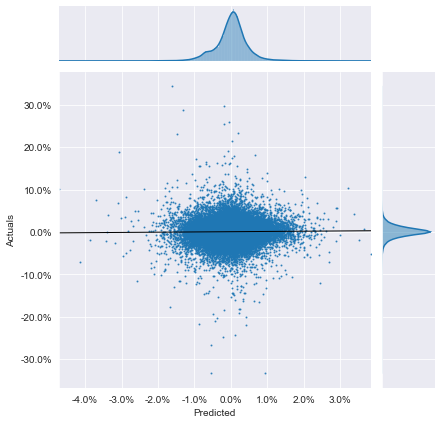

In [17]:
plot_preds_scatter(lr_predictions)

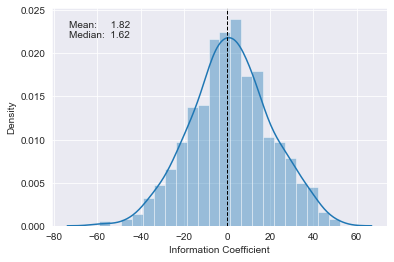

In [18]:
plot_ic_distribution(lr_scores)

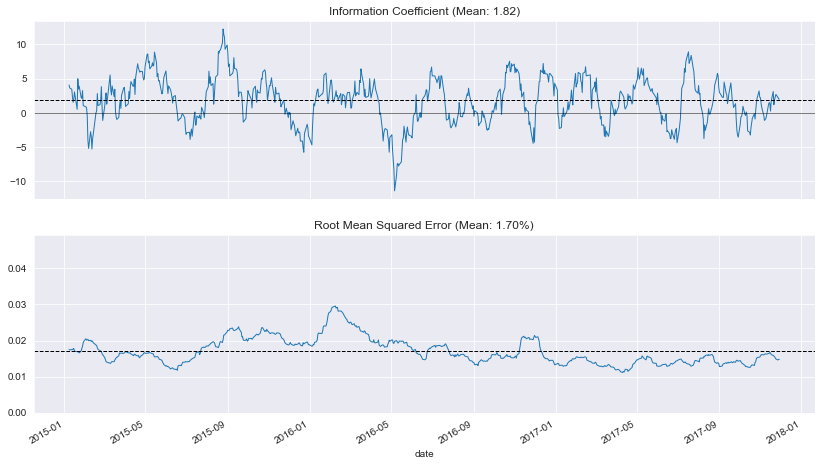

In [19]:
# 21d rolling avg
plot_rolling_ic(lr_scores)

In [20]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))
n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_period_length,
                          lookahead=lookahead, train_period_length=train_period_length)

In [21]:
target = f'target_{lookahead}d'
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [22]:
%%time
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha, fit_intercept=False, random_state=42)

    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: total: 31.5 s
Wall time: 32.6 s


In [23]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('data/data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data/data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('data/data.h5', 'ridge/predictions')
ridge_scores = pd.read_hdf('data/data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('data/data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('data/data.h5', 'ridge/predictions')

In [24]:
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 1.538% (p-value: 0.0000%)


(100.0, 100.0)

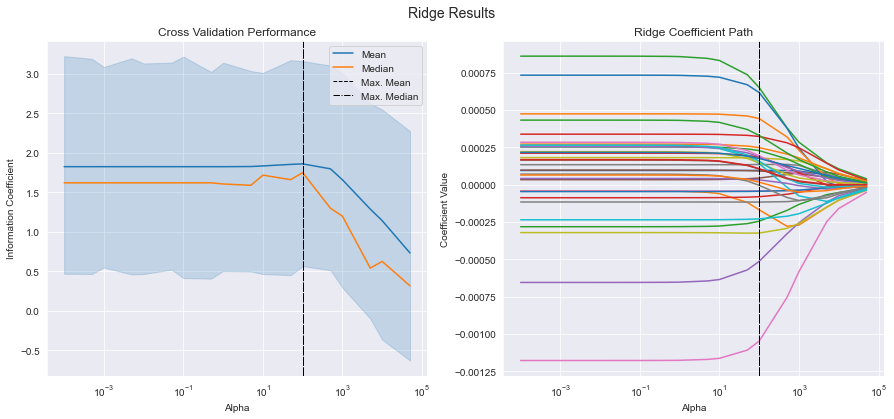

In [39]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 6))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

# seaborn should be downgraded version to 0.11.1 to avoid weird error here(duplicated row/column)
ax = sns.lineplot(x='alpha', y='ic', data=ridge_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
fig.subplots_adjust(top=.9)
best_alpha_mean, best_alpha_median

<Axes: title={'center': 'Top 10 Coefficients'}>

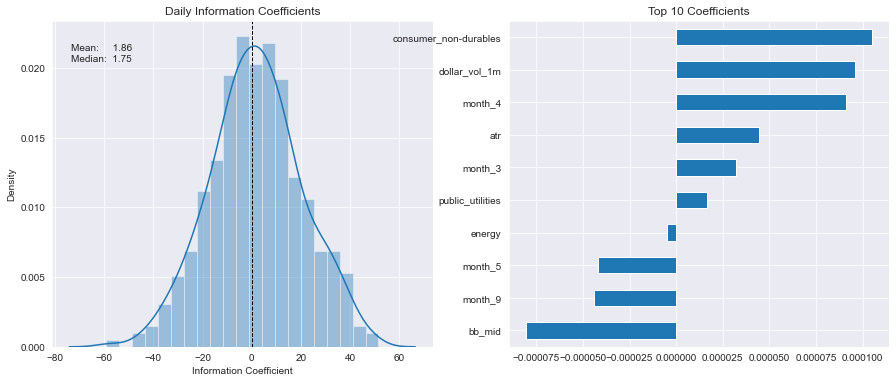

In [26]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

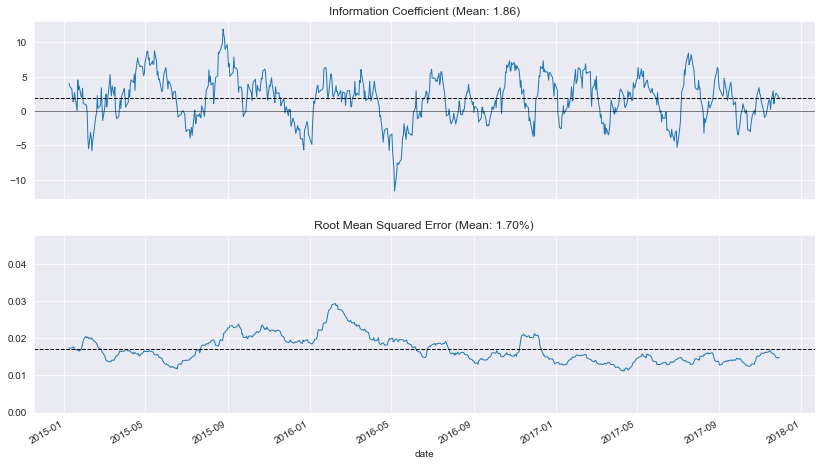

In [27]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

In [41]:
lasso_alphas = np.logspace(-10, -3, 8)
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1
cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_period_length,
                          lookahead=lookahead, train_period_length=train_period_length)

In [44]:
lasso_alphas

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

In [42]:
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [47]:
X.head().append(X.tail())

dollar_vol_1m        rsi   bb_high     bb_mid    bb_low  \
symbol date                                                                  
AAL    2013-07-25  223614.661574  69.669475  0.011251  45.508663  0.140777   
       2013-07-26  234821.351626  72.045207  0.007052  45.869832  0.146370   
       2013-07-29  243001.954091  73.259776  0.008843  46.234899  0.146963   
       2013-07-30  243122.621493  72.532538  0.018500  46.546700  0.142355   
       2013-07-31  256336.659780  73.926238  0.016465  46.926058  0.139949   
ZTS    2014-11-28  294715.115434  71.884144  0.043559  41.262267  0.157493   
       2014-12-01  297525.671580  67.137279  0.051976  41.622201  0.131103   
       2014-12-02  298272.515355  68.612084  0.041573  41.965850  0.120638   
       2014-12-03  295315.035852  69.175766  0.038192  42.247819  0.111125   
       2014-12-04  286390.276661  61.677853  0.051743  42.479366  0.080568   

                        atr      macd  return_1d  return_5d  return_10d  ...  \
symbol date                                                              ...   
AAL    2013-07-25 -0.383445  0.681257   0.017838   0.004413    0.008103  ...   
       2013-07-26 -0.412740  0.772848   0.013808   0.009262    0.008389  ...   
       2013-07-29 -0.494894  0.854980   0.007334   0.011627    0.007984  ...   
       2013-07-30 -0.565684  0.904814  -0.001560   0.012430    0.006755  ...   
       2013-07-31 -0.653399  0.954135   0.007813   0.009025    0.004774  ...   
ZTS    2014-11-28  0.397024  2.806829   0.005820   0.008117    0.003841  ...   
       2014-12-01  0.403122  2.691178  -0.012464   0.002269    0.002815  ...   
       2014-12-02  0.323857  2.615256   0.008339   0.000717    0.001147  ...   
       2014-12-03  0.236555  2.540352   0.003129   0.004380    0.001551  ...   
       2014-12-04  0.273293  2.329735  -0.019608  -0.003018    0.001374  ...   

                   capital_goods  consumer_non-durables  consumer_services  \
symbol date                                                                  
AAL    2013-07-25              0                      0                  0   
       2013-07-26              0                      0                  0   
       2013-07-29              0                      0                  0   
       2013-07-30              0                      0                  0   
       2013-07-31              0                      0                  0   
ZTS    2014-11-28              0                      0                  0   
       2014-12-01              0                      0                  0   
       2014-12-02              0                      0                  0   
       2014-12-03              0                      0                  0   
       2014-12-04              0                      0                  0   

                   energy  finance  health_care  miscellaneous  \
symbol date                                                      
AAL    2013-07-25       0        0            0              0   
       2013-07-26       0        0            0              0   
       2013-07-29       0        0            0              0   
       2013-07-30       0        0            0              0   
       2013-07-31       0        0            0              0   
ZTS    2014-11-28       0        0            1              0   
       2014-12-01       0        0            1              0   
       2014-12-02       0        0            1              0   
       2014-12-03       0        0            1              0   
       2014-12-04       0        0            1              0   

                   public_utilities  technology  transportation  
symbol date                                                      
AAL    2013-07-25                 0           0               1  
       2013-07-26                 0           0               1  
       2013-07-29                 0           0               1  
       2013-07-30                 0           0              

In [43]:
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42, tol=1e-3, max_iter=1000, warm_start=True, selection='random')

    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100).to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 CPU times: total: 51.6 s
Wall time: 45.5 s


In [31]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('data/data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('data/data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('data/data.h5', 'lasso/predictions')

In [32]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 3.555% (p-value: 0.0000%)


In [33]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,1.824181,1.619666
1.000000e-09,1.824352,1.619666
1.000000e-08,1.824861,1.619666
1.000000e-07,1.824624,1.604824
1.000000e-06,1.833256,1.716141
1.000000e-05,1.876567,1.828077
1.000000e-04,1.557386,0.740260
1.000000e-03,1.049272,1.797774


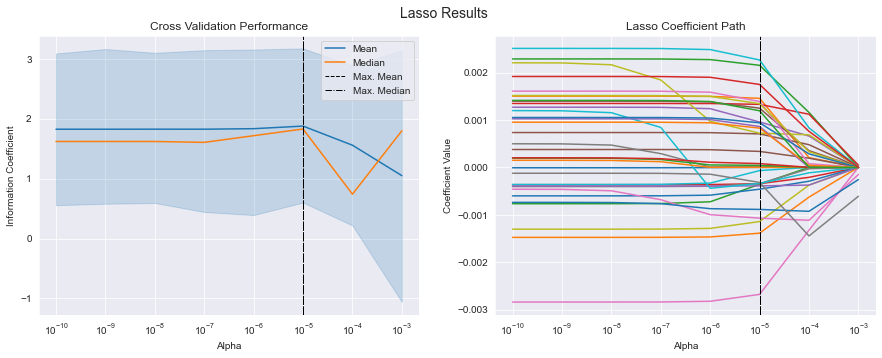

In [34]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.subplots_adjust(top=.9)

<Axes: title={'center': 'Top 10 Coefficients'}>

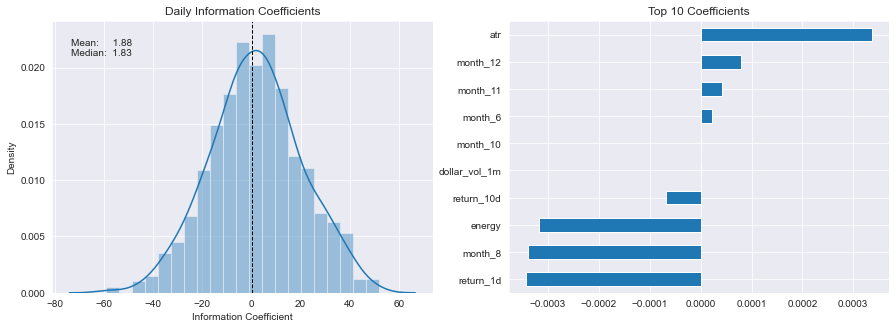

In [35]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

In [36]:
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [53]:
best_ridge_alpha, best_lasso_alpha

(100.0, 1e-05)

In [56]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'), best_ridge_scores.assign(Model='Ridge Regression'), best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

In [59]:
df.tail().append(df.head())

,IC,RMSE,Model
date,,,
2014-12-16,-12.677798,0.031316,Lasso Regression
2014-12-17,32.295609,0.028161,Lasso Regression
2014-12-18,-45.978973,0.021463,Lasso Regression
2014-12-19,14.965986,0.019903,Lasso Regression
2014-12-22,-31.997526,0.018008,Lasso Regression
2017-11-15,14.970449,0.019838,Linear Regression
2017-11-16,-26.201689,0.011922,Linear Regression
2017-11-17,39.029257,0.010336,Linear Regression
2017-11-20,35.578805,0.012878,Linear Regression


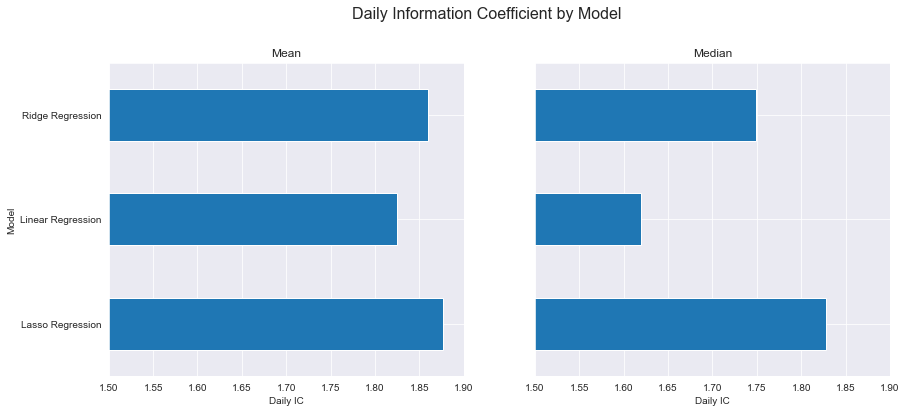

In [70]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,6), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1.65, 2), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1.5, 1.9), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=16)
fig.subplots_adjust(top=.85)

In [61]:
scores

,mean,median
Model,,
Lasso Regression,1.876567,1.828077
Linear Regression,1.824365,1.619666
Ridge Regression,1.859846,1.748928
